# Imports

In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
# enable altair visualizations
alt.renderers.enable()

# opaque background
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

# Load Data Functions

In [3]:
# function to reduce size of dataframes
def downcast_df(file):
    df = pd.read_csv(file)
    
    # isolate data types
    df_int = df.select_dtypes(include=['int64'])
    df_float = df.select_dtypes(include=['float64'])
    df_obj = df.select_dtypes(include=['object'])
    
    # downcast ints and floats
    df_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_float = df_float.apply(pd.to_numeric, downcast='float')
    
    # recombine into single dataframe
    optimized_df = df.copy()
    optimized_df[df_int.columns] = df_int
    optimized_df[df_float.columns] = df_float
    
    # return statement    
    return optimized_df

In [4]:
# function to print out df.info() and df.head() cleanly
def print_info(df):
    print(("=" * 10) + " Info " + ("=" * 10) + "\n")
    print(df.info())
    print("\n" + ("=" * 10) + " First 5 Rows " + ("=" * 10) + "\n")
    print(df.head())

# DataFrames

## Products

In [5]:
products = downcast_df('products.csv')
print_info(products)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null uint16
product_name     49688 non-null object
aisle_id         49688 non-null uint8
department_id    49688 non-null uint8
dtypes: object(1), uint16(1), uint8(2)
memory usage: 582.4+ KB
None

========== First 5 Rows ==========

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  


## Orders

In [17]:
orders = downcast_df('orders.csv')
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(-99)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('int16')
print_info(orders)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  uint32
user_id                   uint32
eval_set                  object
order_number              uint8
order_dow                 uint8
order_hour_of_day         uint8
days_since_prior_order    int16
dtypes: int16(1), object(1), uint32(2), uint8(3)
memory usage: 68.5+ MB
None

========== First 5 Rows ==========

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     -99  


## Aisles

In [7]:
aisles = downcast_df('aisles.csv')
print_info(aisles)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null uint8
aisle       134 non-null object
dtypes: object(1), uint8(1)
memory usage: 1.3+ KB
None

========== First 5 Rows ==========

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


## Departments

In [8]:
departments = downcast_df('departments.csv')
print_info(departments)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null uint8
department       21 non-null object
dtypes: object(1), uint8(1)
memory usage: 269.0+ bytes
None

========== First 5 Rows ==========

   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


## Prior Order Info

In [9]:
prior = downcast_df('order_products__prior.csv')
print_info(prior)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             uint32
product_id           uint16
add_to_cart_order    uint8
reordered            uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 247.5 MB
None

========== First 5 Rows ==========

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


## Training Data

In [10]:
train = downcast_df('order_products__train_cap.csv')
print_info(train)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038515 entries, 0 to 1038514
Data columns (total 4 columns):
order_id             1038515 non-null uint32
product_id           1038515 non-null uint16
add_to_cart_order    1038515 non-null uint8
reordered            1038515 non-null uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 7.9 MB
None

========== First 5 Rows ==========

   order_id  product_id  add_to_cart_order  reordered
0        36       39612                  1          0
1        36       19660                  2          1
2        36       49235                  3          0
3        36       43086                  4          1
4        36       46620                  5          1


## Test Data

In [11]:
test = downcast_df('order_products__test_cap.csv')
print_info(test)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346102 entries, 0 to 346101
Data columns (total 2 columns):
order_id      346102 non-null uint32
product_id    346102 non-null uint16
dtypes: uint16(1), uint32(1)
memory usage: 2.0 MB
None

========== First 5 Rows ==========

   order_id  product_id
0         1       49302
1         1       11109
2         1       10246
3         1       49683
4         1       43633


In [73]:
# from scipy.sparse import coo_matrix
# p_mtx = coo_matrix((prior.order_id.values, (prior.product_id.values, prior.reordered.values)))

# Merge DFs

In [12]:
prior_merge1 = pd.merge(prior, products, on="product_id", how="left")
df = pd.merge(prior_merge1, orders, on="order_id", how="left")
df = df.drop(['eval_set'], axis=1)
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(-1).astype('int16')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8
2,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8
3,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8


In [13]:
# df['count'] = df.groupby('product_id')['reordered'].size()
# df.head()

In [14]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 12 columns):
order_id                  uint32
product_id                uint16
add_to_cart_order         uint8
reordered                 uint8
product_name              object
aisle_id                  uint8
department_id             uint8
user_id                   uint32
order_number              uint8
order_dow                 uint8
order_hour_of_day         uint8
days_since_prior_order    int16
dtypes: int16(1), object(1), uint16(1), uint32(2), uint8(7)
memory usage: 3.3 GB


# Data Exploration

## Time of Day

In [285]:
time_of_day = orders['order_hour_of_day'].value_counts()
time_of_day = time_of_day.reset_index()
time_of_day['pct_of_total'] = np.round((time_of_day['order_hour_of_day'] / time_of_day['order_hour_of_day'].sum()*100), 2)
# time_of_day.head()

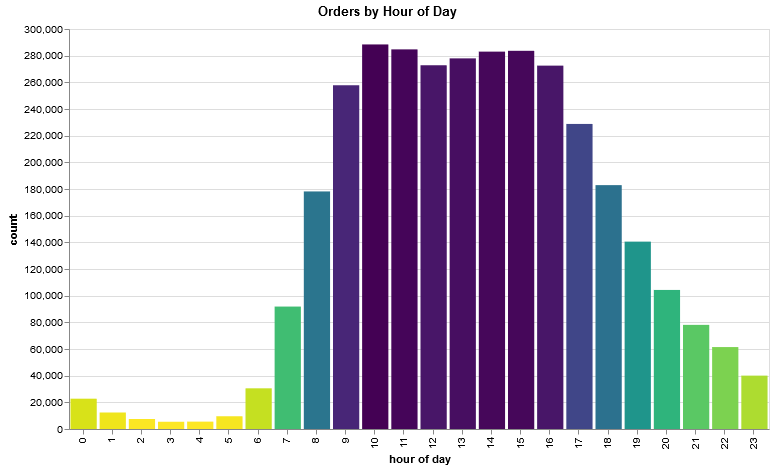

In [289]:
alt.Chart(time_of_day).mark_bar().encode(
    alt.X("index:O", bin=False, title="hour of day"),
    alt.Y('order_hour_of_day:Q', title="count"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('order_hour_of_day', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('index:O', title="Hour of Day"), alt.Tooltip('order_hour_of_day:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Orders by Hour of Day", width=700, height=400)

## Orders by Day of Week

In [73]:
dayofweek_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 0}

inv_dayofweek_dict = {v: k for k, v in dayofweek_dict.items()}

dayofweek_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

In [297]:
dow = orders['order_dow'].value_counts()
dow = dow.reset_index()
dow.columns = ['index', 'count']
dow['pct_of_total'] = np.round((dow['count'] / dow['count'].sum()*100), 2)
dow['day'] = dow['index'].map(inv_dayofweek_dict)
# dow.head()

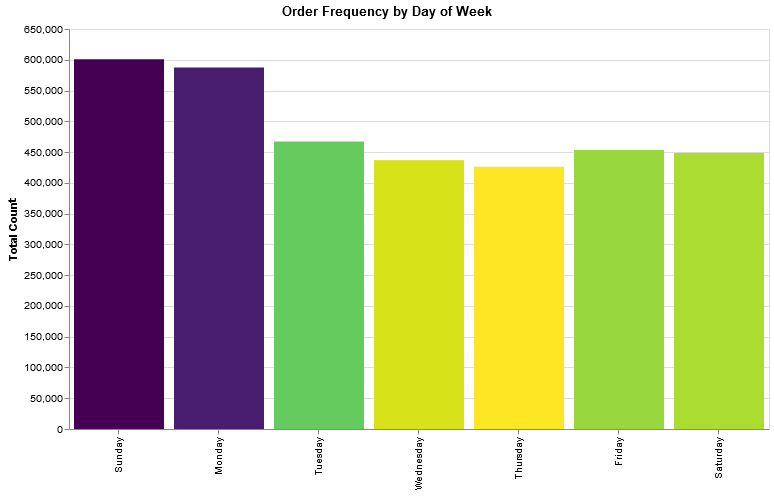

In [301]:
alt.Chart(dow).mark_bar().encode(
    alt.X("day:O", bin=False, sort=dayofweek_list, title=""),
    alt.Y('count:Q', title="Total Count"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('count', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('day:O', title="Day of Week"), alt.Tooltip('count:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Order Frequency by Day of Week", width=700, height=400)

## Days Since Last Order

In [302]:
days_since_prior = orders['days_since_prior_order'].value_counts()
days_since_prior = days_since_prior.reset_index()
days_since_prior.columns = ['days_since_prior_order', 'count']
days_since_prior = days_since_prior.sort_values(by=['days_since_prior_order'])
days_since_prior = days_since_prior.drop(6, axis=0)
days_since_prior = days_since_prior.reset_index(drop=True)
# days_since_prior = days_since_prior.drop('index', axis=1)
# days_since_prior = days_since_prior.reset_index()
days_since_prior['pct_of_total'] = np.round((days_since_prior['count'] / days_since_prior['count'].sum()*100), 2)
# days_since_prior.head()

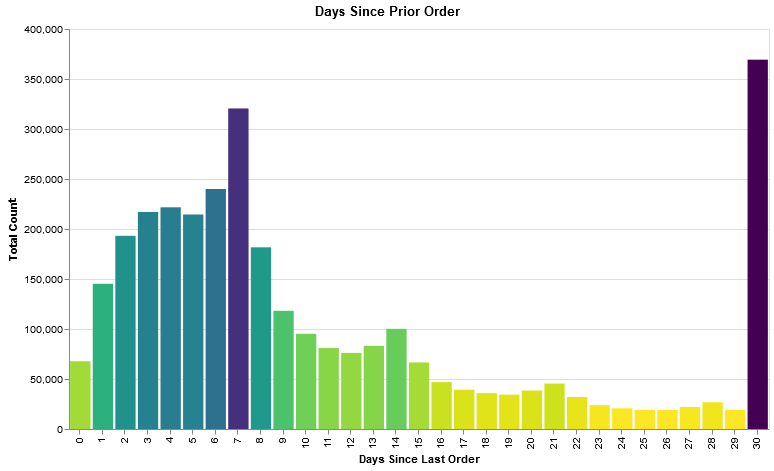

In [304]:
alt.Chart(days_since_prior).mark_bar().encode(
    alt.X("days_since_prior_order:O", bin=False, title="Days Since Last Order"),
    alt.Y('count:Q', title="Total Count"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('count', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('days_since_prior_order:Q', title="Days since Last Order"), alt.Tooltip('count:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Days Since Prior Order", width=700, height=400)

## Orders by Department

In [305]:
dept_stats = df['department_id'].value_counts().reset_index()
dept_stats.columns = ['department_id', 'freq']
dept_stats = pd.merge(dept_stats, departments, on='department_id', how='left')
dept_stats['pct_orders'] = np.round((dept_stats['freq'] / dept_stats['freq'].sum()) * 100,2)
# dept_stats

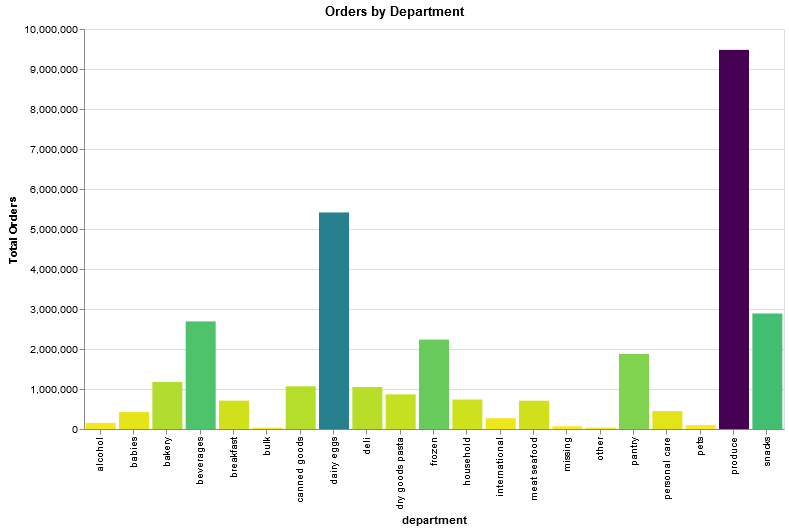

In [308]:
chart_title = "Orders by Department"
x_label = "department:O"
y_label = 'freq:Q'
pct_of_orders = 'pct_orders:Q'
# sort_list = honeycrisp_df['index'].tolist()


alt.Chart(dept_stats).mark_bar().encode(
    alt.X(x_label, bin=False),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Department"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders)]
    ).properties(title=chart_title, width=700, height=400)

## Most Popular Products

In [309]:
# 20 most commonly ordered products
df['product_name'].value_counts()[:20]

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_name, dtype: int64

In [83]:
product_dict = dict(zip(products['product_name'], products['product_id']))

In [104]:
num_orders = orders.shape[0]

top_prods = df['product_name'].value_counts()[:30]
top_prods = pd.DataFrame(top_prods).reset_index()
top_prods.columns = ['index', 'count']
top_prods['product_num'] = top_prods['index'].map(product_dict)
top_prods['Pct_of_Baskets'] = (top_prods['count'] / num_orders) * 100

In [105]:
top_prods.head()

,index,count,product_num,Pct_of_Baskets
0,Banana,472565,24852,13.813316
1,Bag of Organic Bananas,379450,13176,11.091517
2,Organic Strawberries,264683,21137,7.736819
3,Organic Baby Spinach,241921,21903,7.071474
4,Organic Hass Avocado,213584,47209,6.243169


In [65]:
top_prods_order_list = top_prods['index'].tolist()

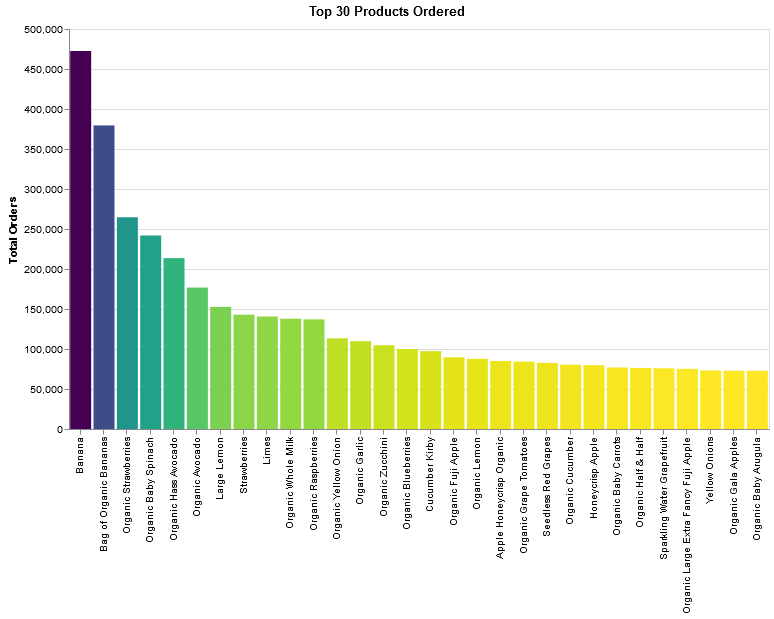

In [311]:
chart_title = "Top 30 Products Ordered"
x_label = "index:O"
y_label = 'count:Q'
pct_of_baskets = 'Pct_of_Baskets:Q'
product_num = 'product_num:O'

alt.Chart(top_prods).mark_bar().encode(
    alt.X(x_label, bin=False, sort=top_prods_order_list, title=""),
    alt.Y(y_label, title="Total Orders"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Product"), alt.Tooltip(y_label), alt.Tooltip(pct_of_baskets), alt.Tooltip(product_num)]
    ).properties(title=chart_title, width=700, height=400)

# Associations

## Items Most Frequently Ordered with Organic Strawberries

In [331]:
ords_org_strawberries = df[df['product_id'] == 21137]['order_id'].tolist()
# ords_org_strawberries[:10]

In [332]:
org_strawberry_df = df[df['order_id'].isin(ords_org_strawberries)]

In [333]:
# top 30 items ordered with organic strawberries
num_org_strawb = org_strawberry_df['product_name'].value_counts()[0]
top_items_org_strawb = org_strawberry_df['product_name'].value_counts()[1:31]
top_items_org_strawb

Bag of Organic Bananas                  61628
Banana                                  56156
Organic Hass Avocado                    40794
Organic Baby Spinach                    38134
Organic Raspberries                     33863
Organic Avocado                         23984
Organic Whole Milk                      23813
Organic Blueberries                     23756
Limes                                   18999
Organic Yellow Onion                    16651
Organic Cucumber                        16555
Large Lemon                             16305
Apple Honeycrisp Organic                15870
Organic Garlic                          15627
Organic Grape Tomatoes                  15573
Organic Zucchini                        15320
Organic Lemon                           15152
Organic Large Extra Fancy Fuji Apple    15113
Seedless Red Grapes                     13935
Organic Whole String Cheese             13513
Organic Gala Apples                     13298
Organic Baby Carrots              

In [337]:
top_items_org_strawb_df = pd.DataFrame(top_items_org_strawb)
top_items_org_strawb_df = top_items_org_strawb_df.reset_index()
top_items_org_strawb_df.columns = ['index', 'count']
top_items_org_strawb_df['pct_orders'] = np.round((top_items_org_strawb_df['count'] / num_org_strawb) * 100,2)
top_items_org_strawb_df['product_num'] = top_items_org_strawb_df['index'].map(product_dict)
# top_items_org_strawb_df.head()

In [338]:
org_straw_order_list = top_items_org_strawb_df['index'].tolist()
# org_straw_order_list

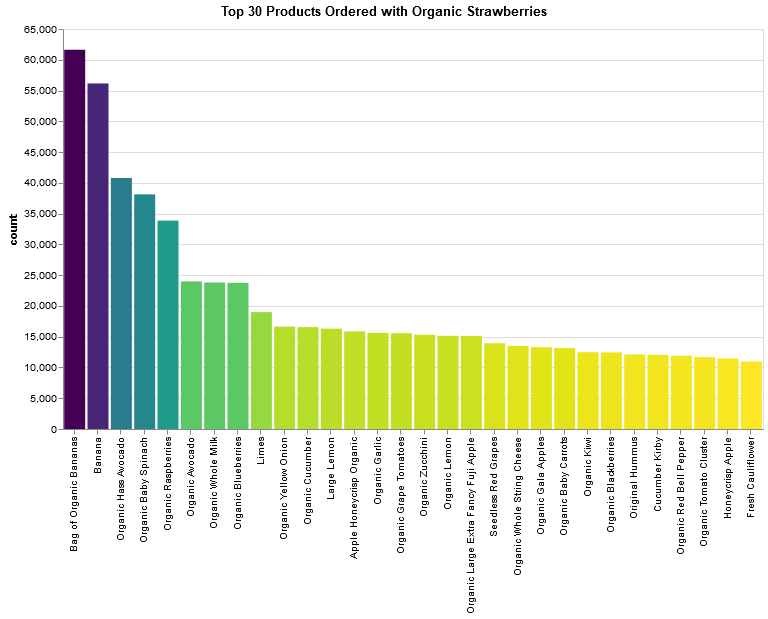

In [339]:
chart_title = "Top 30 Products Ordered with Organic Strawberries"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_num:O'

alt.Chart(top_items_org_strawb_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=org_straw_order_list, title=""),
    alt.Y(y_label),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num)]
    ).properties(title=chart_title, width=700, height=400)

## Items Most Frequently Ordered with Honeycrisp Apples

In [148]:
# find top n items ordered with any particular product by product_id
def top_n_items(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    # top 30 items ordered with organic strawberries
    num_of_main_item = orders_with_item['product_name'].value_counts()[0]
    top_items_with_item = orders_with_item['product_name'].value_counts()[1:n+1]

    top_items_with_item = pd.DataFrame(top_items_with_item)
    top_items_with_item = top_items_with_item.reset_index()
    top_items_with_item.columns = ['index', 'count']
    top_items_with_item['pct_orders'] = np.round((top_items_with_item['count'] / num_of_main_item) * 100, 2)
    top_items_with_item['product_num'] = top_items_with_item['index'].map(product_dict)

    top_items_order_list = top_items_with_item['index'].tolist()
    
    return top_items_with_item

In [149]:
# top 10 items ordered with honeycrisp apples
honeycrisp_df = top_n_items(df, 45066, 10)
honeycrisp_df

,index,count,pct_orders,product_num
0,Banana,28408,35.61,24852
1,Organic Strawberries,11465,14.37,21137
2,Bag of Organic Bananas,11137,13.96,13176
3,Organic Avocado,11046,13.85,47766
4,Organic Baby Spinach,10170,12.75,21903
5,Large Lemon,9485,11.89,47626
6,Organic Hass Avocado,8100,10.15,47209
7,Strawberries,7536,9.45,16797
8,Limes,6993,8.77,26209
9,Cucumber Kirby,6518,8.17,49683


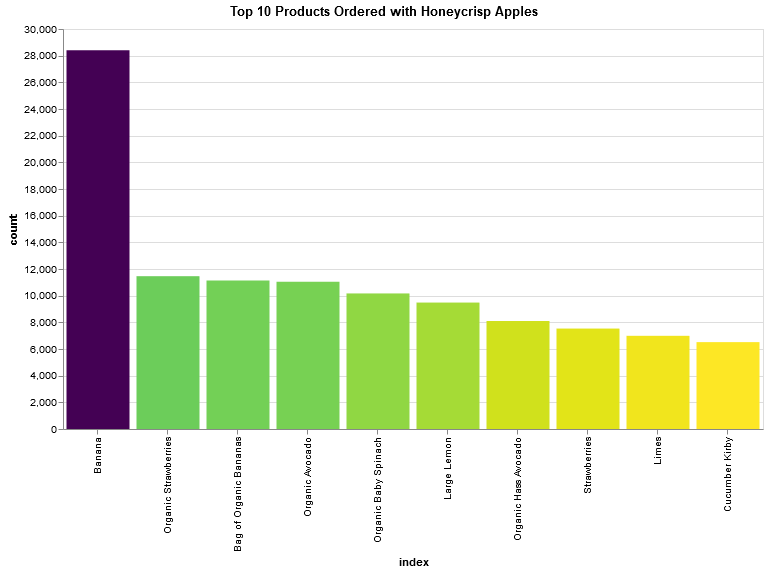

In [154]:
chart_title = "Top 10 Products Ordered with Honeycrisp Apples"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_num:O'
sort_list = honeycrisp_df['index'].tolist()


alt.Chart(honeycrisp_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=sort_list),
    alt.Y(y_label),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num)]
    ).properties(title=chart_title, width=700, height=400)

## Items Most Frequently Ordered with Organic Turkey Burgers

In [152]:
# top 20 items ordered with honeycrisp apples
org_turkey_burger_df = top_n_items(df, 23, 20)
org_turkey_burger_df

,index,count,pct_orders,product_num
0,Banana,179,16.76,24852
1,Bag of Organic Bananas,172,16.10,13176
2,Organic Strawberries,169,15.82,21137
3,Organic Baby Spinach,151,14.14,21903
4,Organic Hass Avocado,135,12.64,47209
5,Organic Avocado,114,10.67,47766
6,Organic Raspberries,101,9.46,27966
7,Organic Baby Carrots,99,9.27,42265
8,Organic Zucchini,82,7.68,45007
9,Large Lemon,75,7.02,47626


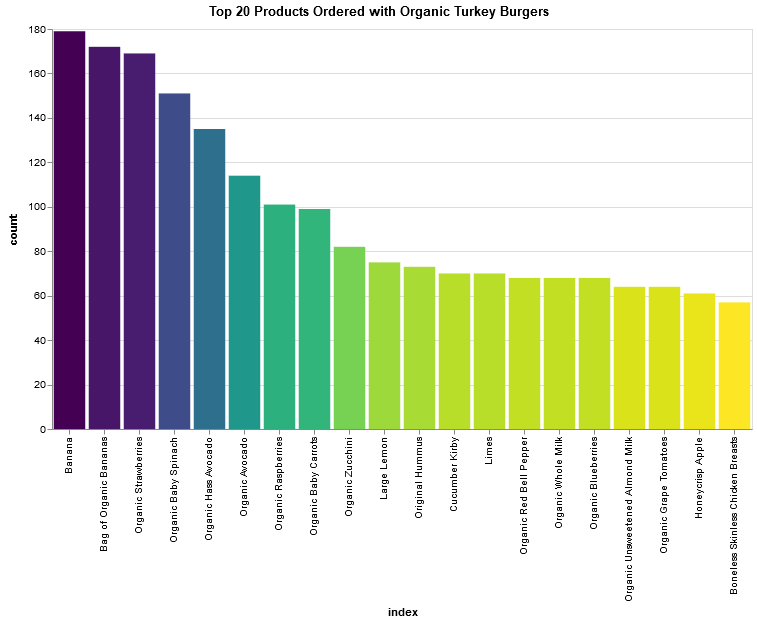

In [153]:
chart_title = "Top 20 Products Ordered with Organic Turkey Burgers"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_num:O'
sort_list = org_turkey_burger_df['index'].tolist()


alt.Chart(org_turkey_burger_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=sort_list),
    alt.Y(y_label),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Days since Prior Order"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num)]
    ).properties(title=chart_title, width=700, height=400)

# Model

In [20]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,36,39612,1,0
1,36,19660,2,1
2,36,49235,3,0
3,36,43086,4,1
4,36,46620,5,1


In [22]:
train.shape

(1038515, 4)

In [25]:
prior.shape[0] / train.shape[0]

31.231603780397972

In [167]:
train_sm = train[:100000].copy()
# train_sm['order'] = 1
# train_sm['order'] = train_sm['order'].astype('uint8')
train_sm.head()

,order_id,product_id,add_to_cart_order,reordered
0,36,39612,1,0
1,36,19660,2,1
2,36,49235,3,0
3,36,43086,4,1
4,36,46620,5,1


In [168]:
train_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
order_id             100000 non-null uint32
product_id           100000 non-null uint16
add_to_cart_order    100000 non-null uint8
reordered            100000 non-null uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 781.3 KB


In [53]:
# train.pivot(index='product_id', columns='order_id', values='reordered')

In [169]:
productPivot = train_sm.pivot(index='order_id', columns='product_id', values='reordered')
# productPivot.loc[~productPivot.isnull()] = 1  # not nan
# productPivot.loc[productPivot.isnull()]
# productPivot
# productPivot = train_sm.pivot(index='order_id', columns='product_id', values='order')

In [170]:
productPivot[productPivot.notnull()] = 1
productPivot[productPivot.isnull()] = 0

In [171]:
productPivot.head()

product_id,1,3,4,9,10,23,25,28,29,30,...,49644,49652,49653,49667,49668,49670,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
from sklearn.metrics.pairwise import cosine_similarity

In [177]:
productPivot.shape

(9402, 16635)

In [191]:
productPivot[:5]

product_id,1,3,4,9,10,23,25,28,29,30,...,49644,49652,49653,49667,49668,49670,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
cosine_similarity(productPivot[:500])[0]

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06681531,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08574929, 0.        , 0.15811388, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09128709, 0.06154575,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14433757, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15811388,
       0.1118034 , 0.        , 0.        , 0.        , 0.     

In [192]:
productPivot.loc[36][productPivot.loc[36] == 1]

product_id
19660    1.0
34497    1.0
39612    1.0
43086    1.0
46620    1.0
46979    1.0
48679    1.0
49235    1.0
Name: 36, dtype: float64

In [218]:
sample_matrix = cosine_similarity(productPivot)[0]

In [239]:
sample_matrix

array([1., 0., 0., ..., 0., 0., 0.])

In [270]:
match_list = []

for i in range(len(sample_matrix)):
    if sample_matrix[i] > 0.3:
        match_list.append(i)
        
# match_list.pop(0)

In [271]:
match_list[:10]

[0, 436, 1709, 1766, 2024, 2052, 2787, 2865, 3056, 3334]

In [282]:
order_match_list = productPivot[productPivot.reset_index().index.isin(match_list)].index.values.tolist()
order_match_list.pop(0)

36

In [283]:
order_match_list

[15462,
 59410,
 61237,
 70422,
 71360,
 97360,
 99543,
 107203,
 116215,
 124424,
 127086,
 129823,
 132320,
 144837,
 150605,
 150721,
 153794,
 158030,
 294266,
 303380]

In [265]:
train_sm[train_sm['order_id'].isin(order_match_list)]['product_id'].value_counts()

19660    13
49235     6
46979     2
30557     1
19354     1
49401     1
21137     1
27086     1
48679     1
31717     1
44449     1
Name: product_id, dtype: int64

In [278]:
sample_order = train_sm[train_sm['order_id']==36].copy()
sample_order['product_name'] = sample_order['product_id'].map(product_dict_inv)
sample_order

,order_id,product_id,add_to_cart_order,reordered,product_name
0,36,39612,1,0,Grated Pecorino Romano Cheese
1,36,19660,2,1,Spring Water
2,36,49235,3,0,Organic Half & Half
3,36,43086,4,1,Super Greens Salad
4,36,46620,5,1,Cage Free Extra Large Grade AA Eggs
5,36,34497,6,1,"Prosciutto, Americano"
6,36,48679,7,1,Organic Garnet Sweet Potato (Yam)
7,36,46979,8,1,Asparagus


In [284]:
matching_vals = pd.DataFrame(train_sm[train_sm['order_id'].isin(order_match_list)]['product_id'].value_counts())
matching_vals = matching_vals.reset_index()
matching_vals.columns = ['index', 'count']
matching_vals['product_name'] = matching_vals['index'].map(product_dict_inv)
matching_vals

,index,count,product_name
0,19660,13,Spring Water
1,49235,6,Organic Half & Half
2,46979,2,Asparagus
3,30557,1,Manzano Banana
4,19354,1,Yo Baby Organic Vanilla Yogurt
5,49401,1,"Chicken Base, Organic"
6,21137,1,Organic Strawberries
7,27086,1,Half & Half
8,48679,1,Organic Garnet Sweet Potato (Yam)
9,31717,1,Organic Cilantro


In [260]:
product_dict_inv = dict([v,k] for k,v in product_dict.items())
# product_dict_inv

In [208]:
cosine_similarity(productPivot[:500])[0][436]

0.35355339059327373

In [205]:
len(cosine_similarity(productPivot[:500])[0])

500

In [194]:
productPivot[22:23]

product_id,1,3,4,9,10,23,25,28,29,30,...,49644,49652,49653,49667,49668,49670,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
1275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
productPivot[436:437]

product_id,1,3,4,9,10,23,25,28,29,30,...,49644,49652,49653,49667,49668,49670,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
15462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
productPivot.loc[1275][productPivot.loc[1275] == 1]

product_id
5450     1.0
6046     1.0
18761    1.0
31506    1.0
48679    1.0
Name: 1275, dtype: float64

In [198]:
productPivot.loc[15462][productPivot.loc[15462] == 1]

product_id
19660    1.0
Name: 15462, dtype: float64

In [48]:
productPivot[45066].head(15)

order_id
36      0.0
38      0.0
170     0.0
226     0.0
349     0.0
456     0.0
719     0.0
762     0.0
844     0.0
878     1.0
915     0.0
988     0.0
1001    0.0
1032    0.0
1042    0.0
Name: 45066, dtype: float64

In [49]:
# bananas
bananas = productPivot[24852]
honeycrisp = productPivot[45066]

In [54]:
train_sm['product_id'].value_counts()[:20]

24852    1332
13176    1151
21137     801
21903     724
47626     604
47766     553
47209     523
16797     466
26209     407
27966     383
27845     374
39275     351
30391     347
45007     320
22935     303
4920      295
8518      291
40706     291
24964     285
42265     284
Name: product_id, dtype: int64

In [50]:
train_sm.groupby('product_id').size()

product_id
1          9
3          1
4          1
9          1
10        14
23         3
25         4
28         1
29         1
30         1
32         2
34        20
36         2
37         3
40         1
41         1
43         1
45        51
47         3
48         1
49        13
54         5
55         1
58         2
62         1
63         5
70         2
77         1
79        10
83         2
        ... 
49593      1
49597      1
49600      2
49602      1
49604      1
49605     24
49608      5
49609      3
49610     27
49611      1
49615      5
49618      2
49621     11
49622      1
49628     16
49633      1
49636      1
49637      3
49638      1
49640      1
49644      2
49652      2
49653      1
49667      7
49668      2
49670      1
49678      1
49680      3
49683    181
49686      1
Length: 16635, dtype: int64

In [55]:
# items similar to honeycrisp apples
similarItems = productPivot.corrwith(honeycrisp)
# similarItems
# similarItems.shape
similarItems = similarItems.dropna()
similarItemsDF = pd.DataFrame(similarItems)
similarItemsDF = pd.merge(similarItemsDF, products, on="product_id", how="inner")
similarItemsDF.columns = ['product_id', 'corr', 'product_name', 'aisle_id', 'department_id']
# similarItemsDF['count'] = df.groupby('product_id')['order'].size()
# similarItemsDF['count'] = train_sm.groupby('product_id').size()

In [56]:
similarItemsDF[30:40]

,product_id,corr,product_name,aisle_id,department_id
30,93,-0.003601,Uncured Cracked Pepper Beef,23,19
31,95,-0.004411,Organic Rice Vinegar,66,6
32,99,-0.003119,Local Living Butter Lettuce,83,4
33,100,-0.001800,Peanut Butter & Strawberry Jam Sandwich,38,1
34,106,-0.003601,Organic Yummy Tummy Maple & Brown Sugar Instan...,92,18
35,113,-0.002546,Infant's Blend Probiotic,70,11
36,115,-0.002546,Scooby-Doo! Fruit Flavored Snacks,50,19
37,116,-0.004765,English Muffins,93,3
38,117,-0.006978,Petit Suisse Fruit,2,16
39,118,-0.001800,Ground Turkey Chub,34,1


In [59]:
similarItemsDF.sort_values(by=['corr'], ascending=False)[:10]

,product_id,corr,product_name,aisle_id,department_id
15047,45066,1.000000,Honeycrisp Apple,24,4
8318,24852,0.105542,Banana,24,4
12170,36287,0.096117,Smooth Operator Natural Peanut Butter,88,13
15934,47626,0.079749,Large Lemon,24,4
5012,14917,0.070179,Blackberry Yogurt,120,16
11776,35147,0.067194,Medium Roast Whole Bean Coffee,26,7
9937,29691,0.067194,Petite Butter Croissant,43,3
1086,3283,0.067194,Peanut Butter Creme Cookies,61,19
13566,40530,0.067194,Soothing Caramel Bedtime Tea,94,7
5346,15925,0.067194,Macaroni and Cheese,38,1


In [114]:
# df.groupby('product_id').agg({'reordered': {np.size}})

In [113]:
counts = df.groupby('product_id').agg({'reordered': {np.size}})
counts[:20]

,reordered
,size
product_id,
1,1852
2,90
3,277
4,329
5,15
6,8
7,30
8,165


In [144]:
count = train_sm.groupby('product_id').size()
count_dict = count.to_dict()
count[:10]

product_id
1      2
3      1
9      1
10     8
23     2
25     1
29     1
34    10
36     1
37     2
dtype: int64

In [147]:
count.describe()

count    11971.000000
mean         4.176761
std         14.267705
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        668.000000
dtype: float64

In [148]:
similarItemsDF['total_count'] = similarItemsDF['product_id'].map(count_dict).astype('int')

In [149]:
similarItemsDF.head()

,product_id,corr,product_name,aisle_id,department_id,count,total_count
0,45,0.447214,European Cucumber,83,4,NaN,25
1,432,-0.500000,Vanilla Almond Breeze Almond Milk,91,16,1852.0,42
2,1158,0.408248,Mango Chunks,116,1,90.0,29
3,1999,-1.000000,Organic Chicken Broth,69,15,277.0,24
4,2078,0.500000,Unsalted Pure Irish Butter,36,16,329.0,25


In [153]:
popularItems = similarItemsDF[similarItemsDF['total_count'] >= 20]

In [156]:
popularItems.sort_values(by=['corr'], ascending=False)[:20]

,product_id,corr,product_name,aisle_id,department_id,count,total_count
96,45066,1.0,Honeycrisp Apple,24,4,198.0,138
43,22825,1.0,Organic D'Anjou Pears,24,4,221.0,68
86,41950,1.0,Organic Tomato Cluster,83,4,130.0,97
36,17794,1.0,Carrots,83,4,129.0,103
59,30720,1.0,Sugar Snap Peas,83,4,28.0,29
33,16185,1.0,Sharp Cheddar Cheese,21,16,32.0,36
38,19348,1.0,Fat Free Milk,84,16,17.0,38
23,10749,1.0,Organic Red Bell Pepper,83,4,1068.0,99
97,45603,1.0,Trilogy Kombucha Drink,31,7,168.0,23
98,46654,1.0,Organic Grade A Large Brown Eggs,86,16,39.0,41


In [165]:
test.shape

(346102, 2)